In [42]:
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.layers import Dense,SpatialDropout1D
import nltk
import numpy as np
import matplotlib.pyplot as plt
nltk.download("punkt")
df = pd.read_csv('np_train_skills_no_commas.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
df = df.dropna()
from collections import Counter

#count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [44]:
text = df['Phrase']
counter = counter_word(text)

In [45]:
num_words = len(counter)
max_length = 20
def split_train_test(features, target, size):
    #size is the size of the training set
    train_size = int(features.shape[0]* size) #check me
    X_train = features[:train_size]
    y_train = target[:train_size]

    X_test = features[train_size:]
    y_test = target[train_size:]
    return X_train, y_train, X_test, y_test

In [46]:
train = df[['Phrase','Target']]
features = train['Phrase']
target = train['Target']
X_train, y_train, X_test, y_test = split_train_test(features, target, 0.8)

In [47]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [48]:
train_sequences = tokenizer.texts_to_sequences(X_train)

In [49]:
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [50]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [51]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])



In [52]:
from tqdm import tqdm
from keras.layers import Dense,SpatialDropout1D
from nltk.tokenize import word_tokenize

"""Creates corpus from feature column, which is a pandas series"""
def create_corpus(df):
    corpus=[]
    for phrase in tqdm(df['Phrase']):
        words=[word.lower() for word in word_tokenize(phrase) if(word.isalpha()==1)]
        corpus.append(words)
    return corpus

In [53]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [54]:
"""Create padded sequences of equal lenght as input to LSTM"""
def create_padded_inputs(corpus):
    MAX_LEN=20
    tokenizer_obj=Tokenizer()
    tokenizer_obj.fit_on_texts(corpus)
    sequences=tokenizer_obj.texts_to_sequences(corpus)

    phrase_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
    return phrase_pad

In [55]:
corpus=create_corpus(df)
phrase_pad = create_padded_inputs(corpus)

100%|██████████| 13004/13004 [00:01<00:00, 11549.93it/s]


In [56]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 4974


In [57]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue

    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 4974/4974 [00:00<00:00, 352127.00it/s]


In [58]:
model_embed = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=20,trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])


opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_embed.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [59]:
model_embed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           497500    
                                                                 
 spatial_dropout1d (Spatial  (None, 20, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 539805 (2.06 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 497500 (1.90 MB)
_________________________________________________________________


In [60]:
X_train, y_train, X_test, y_test = split_train_test(phrase_pad, df['Target'], 0.8)
history=model_embed.fit(X_train,y_train,batch_size=4,epochs=15,validation_split=0.2,verbose=2)


Epoch 1/15
2081/2081 - 62s - loss: 0.6711 - accuracy: 0.6647 - val_loss: 0.5573 - val_accuracy: 0.7751 - 62s/epoch - 30ms/step
Epoch 2/15
2081/2081 - 51s - loss: 0.5691 - accuracy: 0.7088 - val_loss: 0.4631 - val_accuracy: 0.7953 - 51s/epoch - 24ms/step
Epoch 3/15
2081/2081 - 50s - loss: 0.5320 - accuracy: 0.7468 - val_loss: 0.4653 - val_accuracy: 0.7708 - 50s/epoch - 24ms/step
Epoch 4/15
2081/2081 - 51s - loss: 0.5237 - accuracy: 0.7433 - val_loss: 0.4597 - val_accuracy: 0.7717 - 51s/epoch - 24ms/step
Epoch 5/15
2081/2081 - 52s - loss: 0.5173 - accuracy: 0.7477 - val_loss: 0.4608 - val_accuracy: 0.7674 - 52s/epoch - 25ms/step
Epoch 6/15
2081/2081 - 49s - loss: 0.5097 - accuracy: 0.7550 - val_loss: 0.4504 - val_accuracy: 0.7804 - 49s/epoch - 24ms/step
Epoch 7/15
2081/2081 - 51s - loss: 0.5054 - accuracy: 0.7539 - val_loss: 0.4504 - val_accuracy: 0.7746 - 51s/epoch - 25ms/step
Epoch 8/15
2081/2081 - 50s - loss: 0.5028 - accuracy: 0.7538 - val_loss: 0.4400 - val_accuracy: 0.7857 - 50s/ep

In [61]:
def accuracy_loss_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='lower right')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper right')

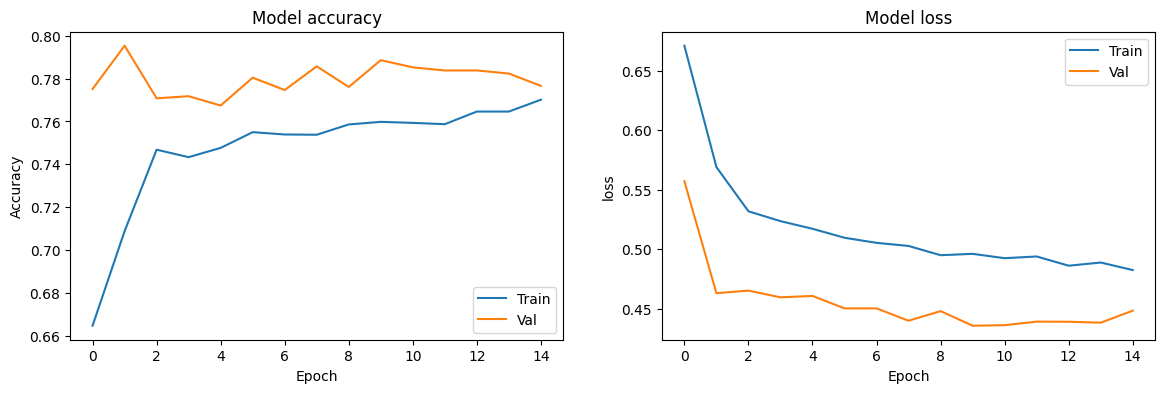

In [62]:
accuracy_loss_plot(history)

In [63]:
accr = model_embed.evaluate(X_test,y_test)
print('Test set\n  Loss for model embed: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

82/82 [==============================] - 1s 6ms/step - loss: 0.4987 - accuracy: 0.7351
Test set
  Loss for model embed: 0.499
  Accuracy: 0.735


82/82 [==============================] - 1s 6ms/step


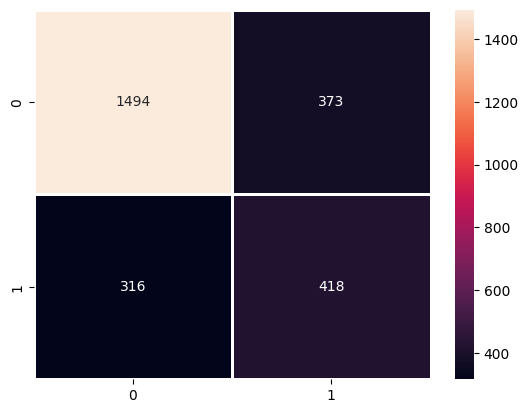

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#convert probabilistic output to binary
y_pred = (model_embed.predict(X_test) > 0.5).astype("int32")
#confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, linewidths = 1, fmt= 'g', annot=True);

In [65]:
#precision, recall, AUC, ROC Curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(y_test, y_pred)
metric = list(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print('Set Accuracy: \t', round(accuracy * 100, 2))
print('Set Precision: \t', round(metric[0], 2))
print('Set Recall: \t', round(metric[1], 2))
print('Set F score: \t', round(metric[2], 2))

Set Accuracy: 	 73.51
Set Precision: 	 0.68
Set Recall: 	 0.68
Set F score: 	 0.68


In [ ]:
model_embed.save('lstm_skill_extractor.h5')